# Iterative Prompt Research

In [62]:
## loading configuration
load_sources : bool = False
load_webpage : bool = load_sources and False
load_filesystem : bool = load_sources and True
load_eurostat : bool = load_sources and True

## execution configuration
execute_tests : bool = False

## evaluation configuration
evaluate_results : bool = True

## Data sources and their cache

### Node and Leaf definitions

In [63]:
from typing import List
from itertools import compress
import pickle
import os

class Node:
    def __init__(self, name : str, predecessor : 'Node' = None, alternative_name : str = None):
        self.name = name
        self.predecessor = predecessor
        self.alternative_name : str = alternative_name
        self.children : List['Node'] = []
        self.is_active : bool = True

    def get_child(self, index : int):
        if (index >= len(self.children)):
            assert IndexError
        return self.children[index]
    
    def add_children(self, children : List['Node']):
        for child in children:
            child.predecessor = self
            self.children.append(child)

    def number_of_children(self) -> int:
        return len(self.children)
    
    def number_of_active_children(self) -> int:
        return sum(1 for child in self.children if child.is_active)

    def __str__(self) -> str:
        return f"{self.name}, #children: {len(self.children)}"
    
    def __repr__(self) -> str:
        return self.__str__()

class Leaf(Node):
    def __init__(self, name : str, predecessor : 'Node' = None, alternative_name : str = None):
        super().__init__(name, predecessor, alternative_name)
    
    def __str__(self) -> str:
        return f"{self.name}"
    
class CorrectPath:
    def __init__(self, root : Node, query : str, child_sequences : List[List['int']]):
        ## sequence must be given in reversed order, having the first move at the last position
        self.root = root
        self.current_node = root
        self.query = query
        self.child_sequences = child_sequences 
        self.__current_step = 0
        self.__available_sequences : List['bool'] = [True for _ in child_sequences]
    
    def is_next_move_correct(self, move_index : int) -> bool:
        if (all(self.__current_step >= len(sequenece) for sequenece in compress(self.child_sequences, self.__available_sequences))): return False
        if (any(move_index == sequence[self.__current_step] and self.current_node.get_child(sequence[self.__current_step]).is_active for sequence in compress(self.child_sequences, self.__available_sequences))): return True
        else: return False
        
    def make_correct_step(self, move_index : int) -> Node | None:
        self.__available_sequences = [(self.__current_step < len(sequence) and sequence[self.__current_step] == move_index) for sequence in self.child_sequences]
        if not any(self.__available_sequences): return None
        self.current_node = self.current_node.get_child(move_index)
        self.__current_step += 1
        return self.current_node
    
    def get_any_correct_step_index(self) -> int | None:
        if (self.is_at_the_end()): return None
        self.__available_sequences = [(self.__current_step < len(sequence)) for sequence in self.child_sequences]
        if not any(self.__available_sequences): return None
        return next(compress(self.child_sequences, self.__available_sequences))[self.__current_step]
    
    def is_at_the_end(self) -> bool:
        return any(self.__current_step >= len(sequence) for sequence in compress(self.child_sequences, self.__available_sequences))
    
    def shortest_path(self) -> int:
        return min(len(sequence) for sequence in self.child_sequences)
    
    def reset(self):
        self.current_node = self.root
        self.__current_step = 0
        self.__available_sequences = [True for _ in self.child_sequences]

def create_test_sequence(root : Node, query : str, child_sequences_str : List['str']) -> 'CorrectPath':
    child_sequences = [[int(x) for x in child_sequence_str.split()] for child_sequence_str in child_sequences_str]
    return CorrectPath(root, query, child_sequences)

#### WorldBank - XML

In [64]:
import xml.etree.ElementTree as ET

worldbank_namespaces =  {
        'nt': 'urn:eu.europa.ec.eurostat.navtree'
    }

def parse_worldbank_xml(path : str) -> Node:
    """Parses the xml tree from the given path and returns the root node."""
    tree = ET.parse(path)
    root = tree.getroot()
    dataset : Node = Node("WorldBank")
    dataset.add_children(get_node_children(root, dataset))
    return dataset

def get_node_children(root : ET.Element, predecessor_node : Node) -> List['Node']:
    """Parses the given root node and returns the corresponding DataSet object."""
    datasets = []
    for branch in root.findall('nt:branch', worldbank_namespaces):
        title = branch.find('nt:title/[@language="en"]', worldbank_namespaces).text
        branch_dataset = Node(title, predecessor_node)
        for child in branch.findall('nt:children', worldbank_namespaces):
            branch_dataset.children = get_node_children(child, branch_dataset)
        datasets.append(branch_dataset)

    for leaf in root.findall('nt:leaf', worldbank_namespaces):
        title = leaf.find('nt:title/[@language="en"]', worldbank_namespaces).text
        datasets.append(Leaf(title, predecessor_node))

    return datasets

In [65]:
worldbank : Node = None

if (load_eurostat):
    if (os.path.exists("worldbank.pkl")):
        worldbank = pickle.load(open("worldbank.pkl", "rb"))
    else:
        worldbank = parse_worldbank_xml("worldBank_content.xml")
        pickle.dump(worldbank, open("worldbank.pkl", "wb"))

worldbank

#### WebPage - HTML

In [66]:
from typing import Dict
from bs4 import BeautifulSoup
from copy import deepcopy
import requests
import time
import re

SLEEP_TIME = 5
TIMEOUT = 10
DEPTH = 5
ATTEMPTS_COUNT = 3

def parse_html_webpage(path : str) -> Node:
    """Parses the html webpage into a tree and returns the root node."""
    dataset = Node("MFF home page", None, path)
    dataset.add_children(get_html_children(dataset, DEPTH, base_url=path))
    return dataset

def get_html_children(predecessor_node : Node, remaining_depth : int, cache : Dict[tuple[str, int], Node] = {}, base_url : str | None = None) -> List['Node']:
    """Parses the given soup and returns the corresponding DataSet object."""
    """If item found in the cachce, it will be returned from there. Key of the cache is the url and the remaining depth."""
    """I can always cut the depth of the children to the required level, but I cannot expand the children if the depth is not enough."""
    child_webpages = []
    if (remaining_depth <= 0): return child_webpages

    attempt_count = 0
    page : requests.Response = None
    soup : BeautifulSoup = None
    while (attempt_count < ATTEMPTS_COUNT):
        try:
            time.sleep(SLEEP_TIME)
            page = requests.get(predecessor_node.alternative_name, timeout=TIMEOUT)
            soup = BeautifulSoup(page.content, 'html.parser')
            break
        except Exception as e:
            print(f"Attempt {attempt_count} failed. Error: {e}")
        finally:
            attempt_count += 1
    
    if (page == None): return child_webpages
    
    for link in soup.find_all('a'):
        if ('href' in link.attrs and link.text.strip() != '' and not url_is_blacklisted(link.attrs['href'], base_url)):
            url = url_get_absolute(link.attrs['href'], predecessor_node.alternative_name)
            ## check if any key with same or higher depth_remaining is in the cache
            key : tuple[str,int] = (url, next((x for x in range(remaining_depth-1, DEPTH, 1) if (url, x) in cache), None))
            if (key[1] is not None): ## if anything found in the cache
                branch_dataset = cache[key] ## take the cached item
                cut_children_depth(branch_dataset, remaining_depth-1) ## cut the depth to the required level
                # branch_dataset.predecessor = predecessor_node ## set the predecessor
                branch_dataset.alternative_name = url ## set the alternative name to its url
            else:
                title = re.sub('[\\n\\s]+',' ',link.text.strip())
                branch_dataset = Node(title, predecessor_node, url) ## create new item
                if (any(k[0] == url and k[1] < remaining_depth for k in cache.keys())):
                    cache = {k:v for k,v in cache.items() if k[0] != url or k[1] > remaining_depth}
                cache[(url, remaining_depth-1)] = branch_dataset
                branch_dataset.add_children(get_html_children(branch_dataset, remaining_depth - 1, cache, base_url)) ## expand the children
                ## remove all chached items with same url and lower depth
            child_webpages.append(branch_dataset) ## add to the children response
    return child_webpages

def url_is_blacklisted(url : str, base_url : str | None = None) -> bool:
    """Checks if the url is blacklisted. Blacklist is very basic."""
    ## keep relatives
    if (url.startswith('./') or (url != "/" and url.startswith('/'))):
        return False
    
    ## filter out some basic stuff
    ## also filter those with different base url if given
    if (url == "/" 
        or url.startswith('#') 
        or url.startswith('mailto:') 
        or url.startswith('javascript:')
        or url.startswith('tel:')
        or (base_url is not None and not url.startswith(base_url))):
        return True

    ## passed
    return False

def url_get_absolute(input : str, current_url : str | None) -> str:
        """Tries to merge the relative input url with the current url prefix to get the absolute url. 
        If no current url is provided, the input is returned."""
        result = ""
        
        if (current_url is None): return input
        ## remove the query string from the url
        if ('?' in current_url): current_url = current_url.split('?')[0]
        ## remove any anchors from the url
        if ('#' in input): input = input.split('#')[0]

        ## try to cut as much from the current url as possible
        if (input.startswith('/')): 
            current_split = [x for x in current_url.split('/') if x != '']
            input_split = [x for x in input.split('/') if x != '']
            for i in range(len(current_split)):
                if (len(input_split) == 0): return current_url
                if (current_split[i] == input_split[0]): input_split.pop(0)
            input = '/'.join(input_split)

            if (current_url.endswith('/')): result = current_url + input
            else: result = current_url + '/' + input
        ## just append the relative to the current
        elif (input.startswith('./')): result = current_url + input.strip('./')
        ## otherwise legit URL given
        else: result = input
        ## always add the trailing slash if not present
        if (not result.endswith('/') and not "." in result.split('/')[-1]): ## only except if file is given
            result += '/'

        return result

def cut_children_depth(node : Node, depth : int):
    """Cuts the tree depth to the given depth."""
    if (depth <= 0):
        node.children = []
        return
    for child in node.children:
        cut_children_depth(child, depth - 1)

In [67]:
webpage : Node = None

if (load_webpage):
    if (os.path.exists("webpage.pkl")):
        webpage = pickle.load(open("webpage.pkl", "rb"))
    else:
        webpage = parse_html_webpage("https://www.mff.cuni.cz/")
        pickle.dump(webpage, open("webpage.pkl", "wb"))

webpage

#### FileSystem - HTML

In [68]:
from bs4 import BeautifulSoup
from collections import deque

def parse_html_file(path : str) -> Node:
    """Parses the html file into a tree and returns the root node."""
    with open(path, 'r', encoding="utf-8") as file:
        soup = BeautifulSoup(file, 'html.parser', from_encoding="utf-8")
        return get_html_file_children(soup)
    
def get_html_file_children(soup : BeautifulSoup) -> Node:
    stack = deque()
    initial_node : Node = None
    previous_node : Node = None
    for link in soup.find_all('a'):
        if ('href' in link.attrs and link.text.strip() != ''):
            url : str = link.attrs['href']
            dir : str = url[:url.rindex('/')]
            file : str = url[url.rindex('/')+1:]
            text : str = link.text.strip()

            if (initial_node is None):
                initial_node = Node(text, None, dir)
                previous_node = initial_node
                continue

            if (file == "" and  dir.startswith(previous_node.alternative_name)): ## when the file is empty, it is a directory
                current_node = Node(text, previous_node, dir)
                previous_node.children.append(current_node)
                stack.append(previous_node)
                previous_node = current_node
            elif (file != "" and dir.startswith(previous_node.alternative_name)): 
                previous_node.children.append(Leaf(text, previous_node, dir))
            else:
                while (len(stack) > 0 and not dir.startswith(previous_node.alternative_name)):
                    previous_node = stack.pop()
                if (file == ""): ## when the file is empty, it is a directory
                    current_node = Node(text, previous_node, dir)
                    previous_node.children.append(current_node)
                    stack.append(previous_node)
                    previous_node = current_node
                elif (file != "" and dir.startswith(previous_node.alternative_name)): 
                    previous_node.children.append(Leaf(text, previous_node, dir))
    return initial_node

In [69]:
filesystem : Node = None

if (load_filesystem):
    if (os.path.exists("filesystem.pkl")):
        filesystem = pickle.load(open("filesystem.pkl", "rb"))
    else:
        filesystem = parse_html_file("filesystem_content.html")
        pickle.dump(filesystem, open("filesystem.pkl", "wb"))

filesystem

## Prompt engineering

### AI Assistant - ChatGPT

In [70]:
from openai import OpenAI
from openAI_secret import API_KEY
from consts import MODEL

class OpenAIWrapper:
    def __init__(self, keep_whole_context : bool, system_message : str):
        self.client = OpenAI(api_key=API_KEY)
        self.keep_whole_context = keep_whole_context
        self.system_message = system_message
        self.messages = [self.__create_system_message(self.system_message)]

    def __create_user_message(self, content):
        return {"role": "user", "content": content}
    
    def __create_system_message(self, content):
        return {"role": "system", "content": content}
    
    def __create_assistant_message(self, content):
        return {"role": "assistant", "content": content}
    
    def __add_message(self, content):
        if (self.keep_whole_context):
            self.messages.append(self.__create_user_message(content))
        else:
            self.messages = [
                self.__create_system_message(self.system_message),
                self.__create_user_message(content) 
            ]

    def __get_response(self):
        full_response = self.client.chat.completions.create(
            model = MODEL,
            messages=self.messages,
            temperature=0,
            timeout=30
        )

        response_content = full_response.choices[-1].message.content
        self.messages.append(self.__create_assistant_message(response_content))
        return response_content
    
    def get_response_to_prompt(self, prompt) -> str:
        """Gets the assistant response to the given prompt. Depeneding on the \"keep_whole_context\" setting, the whole context is kept or just the current prompt is given to the assistant."""
        self.__add_message(prompt)
        response = self.__get_response()
        # for message in self.messages:
        #     print(f"{message['content']}")
        return response if response is not None else ""
    
    def get_additional_response(self, prompt) -> str:
        """Gets a response to the given prompt, but regardless of the \"keep_whole_context\" setting, the previous context is kept."""
        self.messages.append(self.__create_user_message(prompt))
        # for message in self.messages:
        #     print(f"{message['content']}")
        return self.__get_response()

### Prompt generator

In [71]:
from nltk.stem.snowball import SnowballStemmer
from consts import *

class AssistantWorker:
    def __init__(self, stemmer : SnowballStemmer, look_ahead_depth : int = 1):
        self.stemmer = stemmer
        self.look_ahead_depth = look_ahead_depth
        print(MODEL)
        pass

    def create_llm_query(self, initial_query : str, path_done : List['Node'], current_node : Node, mode : int) -> str:
        """Creates a query for the LLM model based on the current node."""
        next_moves = []
        prompt = ""
        steps_so_far = " -> ".join([node.name for node in path_done])

        match mode:
            case WORKER_MODE.STEP_BY_STEP | WORKER_MODE.MATCH_AND_FILTER:
                next_moves = [f"\t{i}: {child.name}\n" for i, child in enumerate([child for child in current_node.children if child.is_active])]
                prompt = (
                f"query: {initial_query}\n"
                f"steps done: {steps_so_far}\n"
                f"next possible subsection names:\n"
                f"{''.join(next_moves)}"
                )
            case WORKER_MODE.LOOK_AHEAD | WORKER_MODE.LOOK_AHEAD_INLINE:
                for i, child in enumerate([child for child in current_node.children if child.is_active]):
                    if (mode == WORKER_MODE.LOOK_AHEAD_INLINE):
                        next_moves.append(f"\t{i}: {self.create_look_ahead_inline_prompt(child, self.look_ahead_depth-1)}\n")    
                    else:
                        next_moves.append(f"{i}: {self.create_look_ahead_prompt(child, self.look_ahead_depth-1, self.look_ahead_depth-1)}")
                prompt = (
                f"query: {initial_query}\n"
                f"steps done: {steps_so_far}\n"
                f"next possible subsection names:\n"
                f"{''.join(next_moves)}"
                )
            case WORKER_MODE.KEYWORD_GEN_AND_MATCH:
                prompt = (
                f"query: {initial_query}\n"
                f"For the query above, please write {NUM_OF_KEYWORDS} keywords that might be relevant names of subsections to dive into in an upcoming search. Prefere single words. Use the language of the query!\n"
                f"Please separate the keywords with semicolon. Dont write anything else!\n"
                )

        return prompt
    
    def create_llm_nonint_message(self) -> str:
        """Creates a message for the user when the answer was not an integer."""
        response = f"You must only return integer, for example 3. If you don't know the answer, return -1"
        return response
    
    def create_llm_wrong_answer_message(self) -> str:
        """Creates a message for the user when the answer was not correct."""
        response = f"Your answer was not correct. Please try another one."
        return response

    def process_llm_child_pick_response(self, raw_response : str) -> int | None:
        """Returns the child index of the llm decision. -1 means the assistant thinks it is the end already, returns NONE if non-digit answer given."""
        response = raw_response.strip()

        if (response == "-1"):
            return -1
        
        if not response.isdigit():
            return None
        else:
            try:
                int_response = int(response)
                return int_response
            except:
                return None

    def process_llm_keyword_gen_response(self, raw_response : str) -> List['str']:
        return [self.stemmer.stem(x.strip().casefold()) for x in raw_response.split(";")]
    
    def create_look_ahead_prompt(self, child : Node, depth_total : int, depth_remaining : int) -> str:
        tab = '\t'
        newline = '\n'
        prompt = f"{''.join([tab for _ in range(depth_total - depth_remaining)])}- {child.name}{newline}"
        
        if depth_remaining == 0:
            return prompt
        
        for i, grandchild in enumerate(child.children):
            prompt += f"{self.create_look_ahead_prompt(grandchild, depth_total, depth_remaining - 1)}"
        return prompt
    
    def create_look_ahead_inline_prompt(self, child : Node, depth_remaining : int) -> str:
        prompt = f"{child.name}"
        if (depth_remaining >= 1):
            prompt += "("
            for grandchild in child.children:
                prompt += f"{self.create_look_ahead_inline_prompt(grandchild, depth_remaining - 1)}, "
            prompt = prompt.strip(", ")
            prompt += ")"
        return prompt

## Testing

### Definitions of text executions

In [72]:
from typing import List, Dict

REPETITION_COUNT = 1

class TestResult:
    def __init__(self):
        self.__steps_taken = 0
        self.__wrong_moves = 0
        self.__non_int_responses = 0
        self.__assisted_answers = 0
        self.sucess = False

    def mark_wrong_move(self):
        """Adds a wrong move to the result. Also increases the steps taken by 1."""
        self.mark_correct_move()
        self.__wrong_moves += 1

    def mark_non_int_responses(self):
        """Adds a non-integer response to the result. Also increases the steps taken by 1."""
        self.mark_correct_move()
        self.__non_int_responses += 1

    def mark_correct_move(self):
        """Increases the steps taken by 1."""
        self.__steps_taken += 1

    def mark_assisted_answer(self):
        """Adds an assisted answer to the result."""
        self.__assisted_answers += 1

    def __str__(self) -> str:
        return f"{'Passed' if self.sucess else 'Failed'}, steps: {self.__steps_taken}, wrong: {self.__wrong_moves}, non-int: {self.__non_int_responses}, assisted: {self.__assisted_answers}, score: {self.get_score()}"
    
    def __repr__(self) -> str: return self.__str__()

    def get_score(self) -> float:
        """Returns a number in range <0,1> where 1 is the best result."""
        return 1 - (self.__wrong_moves / self.__steps_taken)


class TestRunner:
    def __init__(self, stemmer : SnowballStemmer):
        self.stemmer = stemmer
        
    def execute(self, tests : List['CorrectPath'], openai : OpenAIWrapper, worker : AssistantWorker, mode : int) -> List['TestResult']:
        results : List['TestResult'] = []
        for _ in range(REPETITION_COUNT):
            for i, test in enumerate(tests):
                test.reset()
                result = self.__run(test.current_node, test.query, worker, openai, test, mode)
                results.append(result)
                print(f"Test {i}: {result}")
        return results

    def __run(self, root : Node, query : str, worker : AssistantWorker, openai : OpenAIWrapper, correct_path : CorrectPath, mode : int) -> TestResult:
        path_done : List['Node'] = []
        current_node = root
        result : TestResult = TestResult()
        keywords : List[str] = []
        index_translation : Dict[int, int] = {}
        work_mode = mode
        if (mode == WORKER_MODE.KEYWORD_GEN_AND_MATCH):
            keywords = worker.process_llm_keyword_gen_response(openai.get_response_to_prompt(worker.create_llm_query(query, path_done, current_node, mode)))
        
        while (True):
            if (mode == WORKER_MODE.KEYWORD_GEN_AND_MATCH):
                current_node, index_translation = self.__reduce_node(current_node, keywords)
                correct_path.current_node = current_node
                work_mode = WORKER_MODE.STEP_BY_STEP

            if (current_node.number_of_active_children() == 0 and not correct_path.is_at_the_end() and mode == WORKER_MODE.KEYWORD_GEN_AND_MATCH):
                result.mark_wrong_move()
                result.mark_assisted_answer()
                current_node = correct_path.make_correct_step(correct_path.get_any_correct_step_index())
            else:
                prompt = worker.create_llm_query(query, path_done, current_node, work_mode)
                next_child_index = worker.process_llm_child_pick_response(openai.get_response_to_prompt(prompt))
                if (next_child_index is None):
                    result.mark_non_int_responses()
                    additional_prompt = worker.create_llm_nonint_message()
                    next_child_index = worker.process_llm_child_pick_response(openai.get_additional_response(additional_prompt))
                    if (next_child_index is None):
                        result.mark_non_int_responses()
                        result.sucess = False
                        break
                    else:
                        should_break, next_child_index = self.__process_valid_response(next_child_index, result, worker, openai, correct_path, path_done, current_node.number_of_active_children(), index_translation)
                        if (should_break): break
                else:
                    should_break, next_child_index = self.__process_valid_response(next_child_index, result, worker, openai, correct_path, path_done, current_node.number_of_active_children(), index_translation)
                    if (should_break): break

                ## continue to the next node
                # print("-----")
                # print(f"Messages: ")
                # for message in openai.messages:
                #     print(f"{message['role']} : {message['content']}")
                # print(f"Next child: {next_child_index}")
                current_node = correct_path.make_correct_step(next_child_index)
                # print("-----")

            if (correct_path.is_at_the_end()):
                result.sucess = True
                break
            else:
                path_done.append(current_node)
        return result
    
    def __process_valid_response(self, next_child_index : int, result : TestResult, worker : AssistantWorker, openai : OpenAIWrapper, correct_path : CorrectPath, path_done : List['Node'], max_num_of_entries : int, index_translations : Dict['int', 'int'] = {}) -> tuple[bool, int]:
        index_translated : bool = False
        if (index_translations != {} and next_child_index != -1 and next_child_index < correct_path.current_node.number_of_active_children()):
            index_translated = True
            next_child_index = index_translations[next_child_index]
            
        if (correct_path.is_at_the_end()): ## when already at the end
            if (next_child_index == -1): ## if the assistant knows it is the end
                result.mark_correct_move()
                result.sucess = True
                return (True, -1)
            else: ## if the assistant doesn't know it is the end
                result.mark_wrong_move()
                result.sucess = False
                return (True, -1)
        else:
            num_of_tries = 1
            while (
                (not index_translated and next_child_index >= correct_path.current_node.number_of_active_children()) 
                or (not correct_path.is_next_move_correct(next_child_index) and num_of_tries <= max_num_of_entries)
                ):
                index_translated = False
                result.mark_wrong_move()
                wrong_response_prompt = worker.create_llm_wrong_answer_message()
                next_child_index = worker.process_llm_child_pick_response(openai.get_additional_response(wrong_response_prompt))
                if (next_child_index is None):
                    result.mark_non_int_responses()
                    additional_prompt = worker.create_llm_nonint_message()
                    next_child_index = worker.process_llm_child_pick_response(openai.get_additional_response(additional_prompt))
                    if (next_child_index is None):
                        result.mark_non_int_responses()
                        result.mark_assisted_answer()
                        return (False, correct_path.get_any_correct_step_index())
                    else:
                        if (index_translations != {} and next_child_index != -1 and next_child_index < correct_path.current_node.number_of_active_children()):
                            index_translated = True
                            next_child_index = index_translations[next_child_index]
                else:
                    if (index_translations != {} and next_child_index != -1 and next_child_index < correct_path.current_node.number_of_active_children()):
                        index_translated = True
                        next_child_index = index_translations[next_child_index]
                num_of_tries += 1

            if (correct_path.is_next_move_correct(next_child_index)):
                result.mark_correct_move()
                return (False, next_child_index)
            else:
                result.mark_wrong_move()
                result.mark_assisted_answer()
                return (False, correct_path.get_any_correct_step_index())
            
    def __reduce_node(self, node : Node, keywords : List['str']) -> tuple[Node, Dict['int', 'int']]:
        """Reduces the tree based on the given keywords."""
        ## make copy of the node
        reduced_node = deepcopy(node)
        translation = {}
        reduced_index = 0
        for i, child in enumerate(reduced_node.children):
            if (self.__is_relevant(child, keywords)):
                translation[reduced_index] = i
                reduced_index += 1
            else:
                child.is_active = False
        return reduced_node, translation

    def __is_relevant(self, node : Node, keywords : List['str']) -> bool:
        """Checks if the given node is relevant based on the given keywords."""
        return any(keyword in self.stemmer.stem(node.name.strip().casefold()) for keyword in keywords)

### Test creation

#### Worldbank queries
Every test contains a source, a user (human friendly) query to which should be the relevant database table found and a list of sequences of indexes (zero based) that lead to the correct table.

The table of content of whole eurostat database was gathered at February 2024 and is saved locally.

When deciding, whether the current path of the assistant is correct, any matching correct sequence will satisfy. All other sequences that are not following the same path are removed at the first node with a mismatch.
At every step with **N** options, the assistant can take up to **N** steps. The assistant should get to the correct node with the lowest number of steps taken.

In [73]:
worldbank_tests = [
    create_test_sequence(worldbank, "What was the GDP growth rate for Czech Republic in 2019?", [
        "0 1 0 0 0 0"]),
    create_test_sequence(worldbank, "How many people lived in Germany in 2020?", [
        "0 2 1 1 0", "0 2 1 1 1", "0 2 1 1 2", 
        "0 2 1 1 3", "0 2 1 1 4", "0 2 1 1 5", 
        "0 2 1 1 6", "0 2 1 1 7", "0 2 1 1 8", 
        "0 2 1 1 9", "0 2 1 1 10", "0 2 1 1 11", 
        "0 2 1 1 12"]),
    create_test_sequence(worldbank, "What was the unemployment rate in Austria in 2015?", [
        "0 2 7 0 0 2 0", "0 2 7 0 0 2 3", "0 2 7 0 0 2 5", "0 2 7 0 0 2 0"]),
    create_test_sequence(worldbank, "What percentage of the population in Europe had access to clean water and sanitation facilities in 2010?", [
        "1 3 5 0"]),
    create_test_sequence(worldbank, "What was the government expenditure on healthcare in Poland in 2018?", [
        "0 2 4 2 0 0 0", "0 2 4 2 0 1 0"]),
    create_test_sequence(worldbank, "How much renewable energy was consumed as a percentage of total energy consumption in France in 2020?", [
        "0 7 1 0 0 4 0", "0 7 1 0 0 4 8"]),
    create_test_sequence(worldbank, "What was the green-house-gases emissions level for Spain in 2014?", [
        "0 7 0 0 0 0", "0 7 0 0 0 1", "0 7 0 0 0 5", 
        "2 6 0 0", "2 6 0 1", "2 6 0 2", "2 6 0 4"]),
    create_test_sequence(worldbank, "What was the inflation rate in Italy in 2018?", [
        "0 1 4 0 1", "0 1 4 0 4", "0 1 4 0 5"]),
    create_test_sequence(worldbank, "What was the total external debt of Czech Republic in 2021, and how does it compare to its GDP?", [
        "0 1 1 0 1 3", "0 1 1 0 1 0 0", "0 1 1 0 1 0 1", 
        "0 1 1 0 1 0 2", "0 1 1 0 1 0 7", "0 1 1 0 1 0 8", 
        "0 1 1 0 1 0 9"]),
    create_test_sequence(worldbank, "What was the ratio of female to male participation in the labor force in Romania in 2015?", [
        "0 2 7 0 0 0 0", "0 2 7 0 0 1 0", "0 2 7 0 2 2 0", "0 2 7 0 2 2 1", "0 2 7 0 2 2 2",
        "0 2 7 0 2 2 3", "0 2 7 0 2 2 4", "0 2 7 0 2 2 5", "0 2 7 0 2 2 6", "0 2 7 0 2 2 7",
        "0 2 7 0 2 2 8", "0 2 7 0 2 2 9", "0 2 7 0 2 2 10", "0 2 7 0 2 2 11", "0 2 7 0 2 2 12",
        "0 2 7 0 2 2 16", "0 2 7 0 2 2 17", "0 2 7 0 2 2 18", "0 2 7 0 2 2 22", "0 2 7 0 2 2 23",
        "0 2 7 0 2 3 0", "0 2 7 0 2 3 1", "0 2 7 0 2 3 2", "0 2 7 0 2 3 3", "0 2 7 0 2 3 4", "0 2 7 0 2 3 5",
        "0 2 7 0 2 5 0", "0 2 7 0 2 5 1", "0 2 7 0 2 5 2", "0 2 7 0 2 5 3", "0 2 7 0 2 5 5"])
]

#### Filesystem queries

Every test contains a source and an user query to which the assistant should find the best file.
The filesystem was taken from my personal HDD drive of many documents, photos and files.
The files are not located in the same depth as in eurostat database. 
User queries were therefore made more "user-like" and less "ultra-specific".

In [74]:
filesystem_tests = [
    create_test_sequence(filesystem, "Najdi můj LocatorForm z roku 2021, který jsem potřeboval kvůli pandemii covidu pro vstup do Británie.", [
        "7 5 0"
    ]),
    create_test_sequence(filesystem, "Najdi moje potvrzení o zdanitelných přijmech z roku 2022 od firmy LOKOTRAIN.", [
        "10 1 2"
    ]),
    create_test_sequence(filesystem, "Najdi zdrojový kód projektu na zobrazení předpovědi počasí na procesor ESP32.", [
        "14 5 6 0"
    ]),
    create_test_sequence(filesystem, "Najdi můj záznam docházi v práci LokoTrain za měsíc Leden 2022.", [
        "21 1 1 5"
    ]),
    create_test_sequence(filesystem, "Najdi dokument o konstrukci asynchronního motoru z kurzu společnosti LokoTrain.", [
        "21 6 5 2"
    ]),
    create_test_sequence(filesystem, "Najdi nový formulář pro hlášení závady na lokomotivě, vyrobený pro firmu LokoTrain.", [
        "21 6 9 1"
    ]),
    create_test_sequence(filesystem, "Najdi \"lokousage\" soubor z října 2021, který reportujeme pro LokoTrain každý měsíc.", [
        "21 4 0 4"
    ]),
    create_test_sequence(filesystem, "Najdi rozpad energie od DBE pro dopravce CDC za květen 2022 vytvořený firmou LokoTrain.", [
        "21 0 6 1 4 2"
    ]),
    create_test_sequence(filesystem, "Najdi avizo o změně registrační poznávací značky na mém autě značky Škoda Octavia.", [
        "24 0"
    ]),
    create_test_sequence(filesystem, "Najdi soubor se všemi prozrazenými lidskými hesly pro penetrační testování.", [
        "28 0 0"
    ]),
    create_test_sequence(filesystem, "Najdi fakturu o koupi mého kola SpaceChicken od firmy PlanetX.", [
        "30 2 2", "30 2 3"
    ]),
    create_test_sequence(filesystem, "Najdi AutoCAD soubor s návrhem rodinného domu ve Hvězdonicích pro modelové kolejiště na Podbabě.", [
        "31 0 1"
    ]),
    create_test_sequence(filesystem, "Najdi vstupenky do musea Becherovky.", [
        "39 0"
    ]),
    create_test_sequence(filesystem, "Najdi ukázkový zdrojový soubor pro knihovnu na ovládání více tlačítek, kterou používám u projektu \"DPP TABLA\", který byl napsaný na ESP32", [
        "14 2 0 0 1 2"
    ])
    
]

### Test execution

#### Worldbank

In [75]:
from datetime import datetime
from consts import WORKER_MODE, MODEL
import pickle

if (execute_tests):
    system_message = "You are an assistant that is helping a user to navigate through the World Bank data.\
        You are given a query and all available subsections.\
        You should help the user to navigate to the correct subsection.\
        Answer only with the number of the subsection.\
        If you don't know the answer, return -1."
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    runner = TestRunner(stemmer)
    openai = OpenAIWrapper(False, system_message)

    current_date = datetime.now().strftime("%Y-%m-%d")
    
    worker = AssistantWorker(stemmer)
    eurostat_stepbystep_results = runner.execute(worldbank_tests, openai, worker, WORKER_MODE.STEP_BY_STEP)
    pickle.dump(eurostat_stepbystep_results, open(f"eurostat_{MODEL}_step-by-step_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=2)
    eurostat_look_ahead_2_results = runner.execute(worldbank_tests, openai, worker, WORKER_MODE.LOOK_AHEAD)
    pickle.dump(eurostat_look_ahead_2_results, open(f"eurostat_{MODEL}_look-ahead-2_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=3)
    eurostat_look_ahead_3_results = runner.execute(worldbank_tests, openai, worker, WORKER_MODE.LOOK_AHEAD)
    pickle.dump(eurostat_look_ahead_3_results, open(f"eurostat_{MODEL}_look-ahead-3_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=4)
    eurostat_look_ahead_4_results = runner.execute(worldbank_tests, openai, worker, WORKER_MODE.LOOK_AHEAD)
    pickle.dump(eurostat_look_ahead_4_results, open(f"eurostat_{MODEL}_look-ahead-4_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=2)
    eurostat_look_ahead_inline_2_results = runner.execute(worldbank_tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE)
    pickle.dump(eurostat_look_ahead_inline_2_results, open(f"eurostat_{MODEL}_look-ahead-inline-2_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=3)
    eurostat_look_ahead_inline_2_results = runner.execute(worldbank_tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE)
    pickle.dump(eurostat_look_ahead_inline_2_results, open(f"eurostat_{MODEL}_look-ahead-inline-3_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=4)
    eurostat_look_ahead_inline_4_results = runner.execute(worldbank_tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE)
    pickle.dump(eurostat_look_ahead_inline_4_results, open(f"eurostat_{MODEL}_look-ahead-inline-4_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer)
    eurostat_keyword_gen_results = runner.execute(worldbank_tests, openai, worker, WORKER_MODE.KEYWORD_GEN_AND_MATCH)
    pickle.dump(eurostat_keyword_gen_results, open(f"eurostat_{MODEL}_keyword-gen_results_{current_date}.pkl", "wb"))

#### Filesystem

In [76]:
from datetime import datetime
from consts import WORKER_MODE, MODEL
import pickle

if (execute_tests):
    system_message = "You are an assistant that is helping a user to navigate through the user document file system.\
        You are given a query and all available subdirectories or files.\
        You should help the user to navigate to the correct file.\
        Answer only with the number of the subdirectory / file.\
        If you don't know the answer, return -1."
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    runner = TestRunner(stemmer)
    openai = OpenAIWrapper(False, system_message)

    current_date = datetime.now().strftime("%Y-%m-%d")
    
    worker = AssistantWorker(stemmer)
    filesystem_stepbystep_results = runner.execute(filesystem_tests, openai, worker, WORKER_MODE.STEP_BY_STEP)
    pickle.dump(filesystem_stepbystep_results, open(f"filesystem_{MODEL}_step-by-step_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=2)
    filesystem_look_ahead_2_results = runner.execute(filesystem_tests, openai, worker, WORKER_MODE.LOOK_AHEAD)
    pickle.dump(filesystem_look_ahead_2_results, open(f"filesystem_{MODEL}_look-ahead-2_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=3)
    filesystem_look_ahead_3_results = runner.execute(filesystem_tests, openai, worker, WORKER_MODE.LOOK_AHEAD)
    pickle.dump(filesystem_look_ahead_3_results, open(f"filesystem_{MODEL}_look-ahead-3_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=4)
    filesystem_look_ahead_4_results = runner.execute(filesystem_tests, openai, worker, WORKER_MODE.LOOK_AHEAD)
    pickle.dump(filesystem_look_ahead_4_results, open(f"filesystem_{MODEL}_look-ahead-4_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=2)
    eurostat_look_ahead_inline_2_results = runner.execute(worldbank_tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE)
    pickle.dump(eurostat_look_ahead_inline_2_results, open(f"filesystem_{MODEL}_look-ahead-inline-2_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=3)
    eurostat_look_ahead_inline_3_results = runner.execute(worldbank_tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE)
    pickle.dump(eurostat_look_ahead_inline_3_results, open(f"filesystem_{MODEL}_look-ahead-inline-3_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer, look_ahead_depth=4)
    eurostat_look_ahead_inline_4_results = runner.execute(worldbank_tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE)
    pickle.dump(eurostat_look_ahead_inline_4_results, open(f"filesystem_{MODEL}_look-ahead-inline-4_results_{current_date}.pkl", "wb"))

    worker = AssistantWorker(stemmer)
    filesystem_keyword_gen_results = runner.execute(filesystem_tests, openai, worker, WORKER_MODE.KEYWORD_GEN_AND_MATCH)
    pickle.dump(filesystem_keyword_gen_results, open(f"filesystem_{MODEL}_keyword-gen_results_{current_date}.pkl", "wb"))

## Evaluation

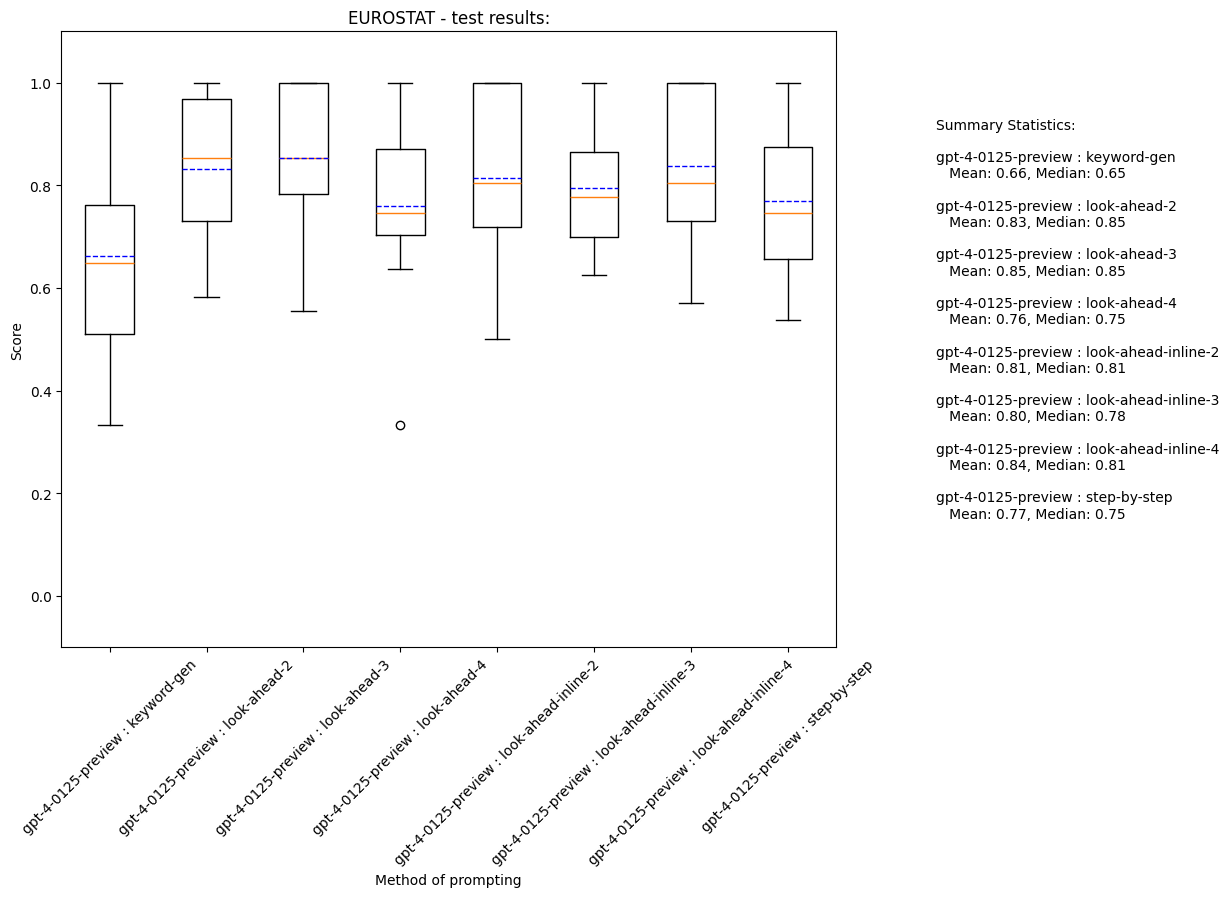

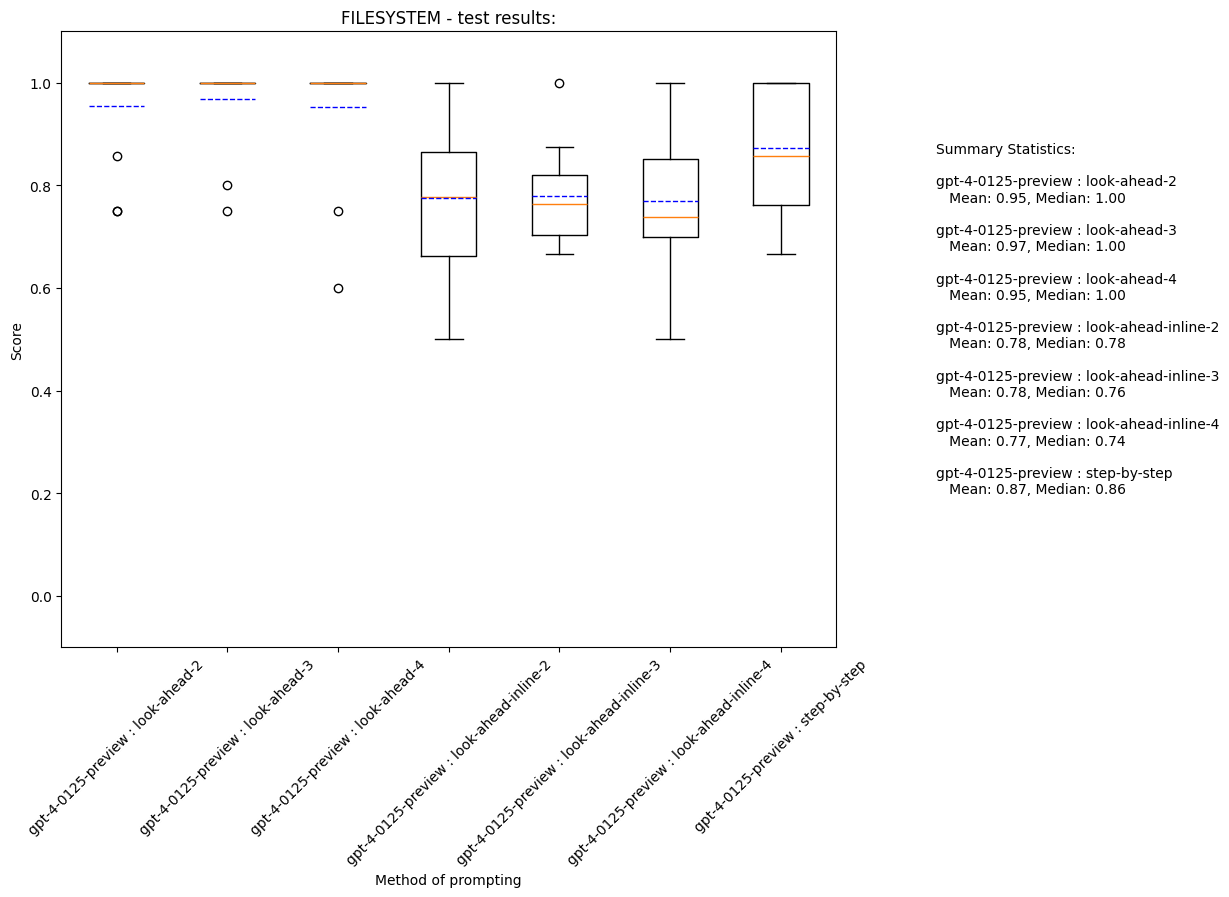

In [77]:
import pickle
from datetime import datetime
from os import listdir
from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np

ignore_dates : bool = False

if (evaluate_results):
    for test_type in ["eurostat", "filesystem"]:
        ## load the newest results
        _result_files = list(filter(lambda x: x.startswith(f"{test_type}_") and x.endswith(".pkl"), listdir()))
        if (_result_files == []): continue

        _result_files : List[str] = []
        if (ignore_dates):
            _newest_date = max([datetime.strptime(x.split("_")[-1].split(".")[0], "%Y-%m-%d") for x in _result_files])
            _result_files = list(filter(lambda x: x.startswith(f"{test_type}_") and x.endswith(".pkl") and x.split("_")[-1].startswith(_newest_date.strftime("%Y-%m-%d")), listdir()))
        else:
            _result_files = list(filter(lambda x: x.startswith(f"{test_type}_") and x.endswith(".pkl"), listdir()))

        _result_tests : Dict[str, List['TestResult']] = {_file : pickle.load(open(_file, "rb")) for _file in _result_files}
        _data = {" : ".join(k.split("_")[1:3]) : [x.get_score() for x in v] for k,v in _result_tests.items()}

        if _data == {}: continue

        ## plot the boxplot
        plt.figure(figsize=(10, 8))
        plt.boxplot(x = _data.values(), labels = _data.keys(), showmeans=True, meanline=True, meanprops={'color':'blue'})
        plt.xticks(rotation=45)
        plt.ylim(-0.1,1.1)
        plt.title(f"{test_type.upper()} - test results:")
        plt.xlabel("Method of prompting")
        plt.ylabel("Score")
        
        ## Add side table with mean and median values
        table_text = "Summary Statistics:\n\n"
        for label, scores in _data.items():
            mean_score = np.mean(scores)
            median_score = np.median(scores)
            table_text += f"{label}\n   Mean: {mean_score:.2f}, Median: {median_score:.2f}\n\n"
        
        plt.figtext(1.0, 0.5, table_text, fontsize=10, ha='left', va='center')

        plt.show()
            
                